In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import math
import os
import scipy

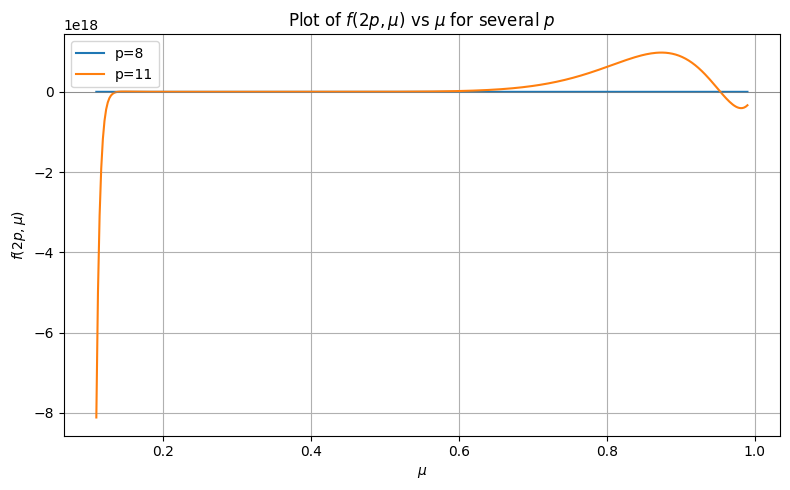

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

def f_of_2p(mu, p, k_star=None):
    """
    Compute f(2p, mu) for given mu array (or scalar) and integer p>=1.
    By default k_star = p (assumption). If you want a different k*, pass it.
    
    Parameters
    ----------
    mu : array_like or scalar
        Values of mu at which to evaluate the function. If mu contains 0 and
        there are negative integer exponents, results may be infinite or large.
    p : int
        Positive integer p (p >= 1).
    k_star : int or None
        Value for k^*. If None, defaults to p.
        
    Returns
    -------
    vals : numpy.ndarray
        Same shape as mu, containing f(2p, mu).
    """
    if p < 1 or not isinstance(p, int):
        raise ValueError("p must be an integer >= 1")
    if k_star is None:
        k_star = p

    mu = np.asarray(mu, dtype=float)
    # We'll broadcast mu to 1D for vectorized computation:
    mu_flat = mu.ravel()
    result = np.zeros_like(mu_flat, dtype=float)

    for m in range(1, p+1):
        # coefficient A_m = (2m-1)! / (m! (m-1)! 2^{2m-1})
        A_num = factorial(2*m - 1, exact=False)
        A_den = factorial(m, exact=False) * factorial(m-1, exact=False) * (2.0**(2*m-1))
        A_m = A_num / A_den

        # inner sum over t = 0 .. 2m-1
        inner_sum = np.zeros_like(mu_flat, dtype=float)
        for t in range(0, 2*m):
            comb_den = factorial(t, exact=False) * factorial(2*m - 1 - t, exact=False)
            prefactor = (1.0 - (p / m) + (p / m) * (mu_flat**2)) / comb_den

            exponent = 2*(k_star - 2*m + t)  # integer exponent
            # handle possible negative exponents at mu == 0 by using np.where
            # mu_flat**exponent is fine for exponent >= 0. For negative exponents,
            # we compute 1/(mu**(-exponent)) but protect zeros with a small epsilon.
            if np.any(exponent < 0):
                # compute mu**exponent robustly:
                with np.errstate(divide='ignore', invalid='ignore'):
                    mu_pow = np.where(mu_flat == 0.0,
                                      np.inf,  # set to 0 (or np.inf) if needed; here 0 to avoid crash
                                      mu_flat ** exponent)
            else:
                mu_pow = mu_flat ** exponent

            sign = (-1.0) ** (2*m - 1 - t)
            inner_sum += prefactor * mu_pow * sign

        result += A_m * inner_sum

    # reshape to original mu shape
    return result.reshape(mu.shape)


if __name__ == "__main__":
    # Example plotting for p = 2,3,4,5 (you can change or extend this list)
    p_values = [8, 11] #, 4, 5]
    # mu range: avoid exactly zero if you expect negative exponents; here include small epsilon
    mu = np.linspace(0.11, 0.99, 400)
    # if you expect negative exponents and want to avoid division-by-zero, you can shift mu slightly:
    # mu = np.linspace(-2.0, 2.0, 400)
    # mu[mu == 0] = 1e-12

    plt.figure(figsize=(8, 5))
    for p in p_values:
        y = f_of_2p(mu, p)          # uses default k_star = p
        plt.plot(mu, y*mu**(-1)*factorial(2*p)/(2*p), label=f"p={p}")

    plt.axhline(0, color='gray', linewidth=0.7, alpha=0.7)
    plt.xlabel(r'$\mu$')
    plt.ylabel(r'$f(2p,\mu)$')
    plt.title(r'Plot of $f(2p,\mu)$ vs $\mu$ for several $p$')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()